In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import rasterio as rio
%matplotlib inline

In [4]:
for year in range(2016, 2020):
    deets = pd.read_csv("Data/Raw Data Files/Details_"+str(year)+".csv")
    locs = pd.read_csv("Data/Raw Data Files/Locations_"+str(year)+".csv")
    fatalities = pd.read_csv("Data/Raw Data Files/Fatalities_"+str(year)+".csv")
    print(year, deets.shape, locs.shape, fatalities.shape)

(2016, (56003, 51), (41619, 11), (669, 11))
(2017, (57024, 51), (42310, 11), (776, 11))
(2018, (62351, 51), (47876, 11), (799, 11))
(2019, (46621, 51), (46486, 11), (400, 11))


# Initial Data Wrangling and Exploration

In [5]:
df = pd.read_csv("Data/Raw Data Files/Details_2019.csv")

casualty_cols = ['INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT']
damage_cols = ['DAMAGE_PROPERTY', 'DAMAGE_CROPS']

df['CASUALTIES'] = df[casualty_cols].sum(axis=1)
df['DAMAGES'] = df[damage_cols].sum(axis=1) #need to parse strings, and convert to numeric!
df['DURATION'] = (pd.to_datetime(df['END_DATE_TIME']).subtract(pd.to_datetime(df['BEGIN_DATE_TIME']))).astype('timedelta64[h]')

In [6]:
casualty_cols = ['INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT']
damage_cols = ['DAMAGE_PROPERTY', 'DAMAGE_CROPS']
dt_factors = ['YEAR','MONTH_NAME','STATE_FIPS']
excluded_factors = ['CATEGORY','WFO']+dt_factors+casualty_cols+damage_cols
df.drop(excluded_factors, axis=1, inplace=True)
df.drop(df.filter(regex='BEGIN|END|CZ|TOR\_OTHER'), axis=1, inplace=True)

In [7]:
print(list(df))#['EVENT_TYPE'].unique())

['EPISODE_ID', 'EVENT_ID', 'STATE', 'EVENT_TYPE', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'CASUALTIES', 'DAMAGES', 'DURATION']


In [9]:
real_df = df[['MAGNITUDE','TOR_LENGTH','TOR_WIDTH','DURATION','CASUALTIES']]
real_df.fillna(0, inplace=True)
full_x = real_df[['MAGNITUDE','TOR_LENGTH','TOR_WIDTH','DURATION']]
full_y = real_df['CASUALTIES']
x_train, x_test, y_train, y_test = train_test_split(full_x, full_y, train_size=0.8, random_state=4741)

C:\Anaconda2\lib\site-packages\pandas\core\frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
print(df.corr()['CASUALTIES'])
print(df['CASUALTIES'].shape,real_df['CASUALTIES'][real_df['CASUALTIES']>0].shape)

EPISODE_ID   -0.004733
EVENT_ID     -0.004844
MAGNITUDE     0.016609
TOR_LENGTH    0.221514
TOR_WIDTH     0.130926
CASUALTIES    1.000000
DAMAGES            NaN
DURATION     -0.001560
Name: CASUALTIES, dtype: float64
((46621,), (502,))


## Initial Models

In [12]:
model = LinearRegression()
model.fit(x_train,y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_test, y_test))

('Training accuracy: ', 0.022690459030367482)
('Cross validation accuracy: ', 0.03498550602538475)


In [39]:
cat_df = df[['EVENT_TYPE','FLOOD_CAUSE','MAGNITUDE','TOR_LENGTH','TOR_WIDTH','DURATION','CASUALTIES']]
cat_df.fillna(0, inplace=True)
full_x = cat_df[['EVENT_TYPE','FLOOD_CAUSE','MAGNITUDE','TOR_LENGTH','TOR_WIDTH','DURATION']].pipe(
    pd.get_dummies,
    prefix_sep='_', 
    drop_first=True
)
full_y = cat_df['CASUALTIES']

In [40]:
x_train, x_test, y_train, y_test = train_test_split(full_x, full_y, train_size=0.8, random_state=4741)

In [41]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(x_train,y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_test, y_test))

('Training accuracy: ', 0.39911497853991984)
('Cross validation accuracy: ', 0.013525905848925768)


# Additional Data Exploration

In [15]:
df['EVENT_TYPE'][df['EVENT_TYPE'].str.match(".*Flood$")] = "Flood"
df['EVENT_TYPE'][df['EVENT_TYPE'].str.match(".*Wind$")] = "Wind"
df['EVENT_TYPE'][df['EVENT_TYPE'].str.contains(".*Hail$")] = "Hail"
df.groupby(['EVENT_TYPE']).agg({'CASUALTIES':np.sum, 'EVENT_ID':np.size})

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,EVENT_ID,CASUALTIES
EVENT_TYPE,,
Astronomical Low Tide,13,0
Avalanche,38,14
Blizzard,681,16
Cold/Wind Chill,390,23
Debris Flow,135,2
Dense Fog,322,47
Drought,178,0
Dust Devil,7,25
Dust Storm,18,0


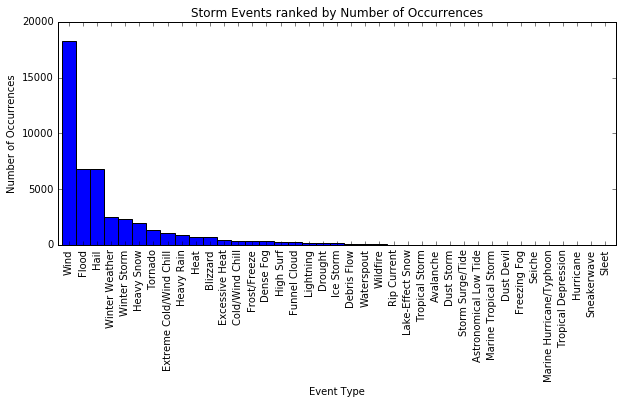

In [16]:
ax1 = df['EVENT_TYPE'].value_counts().plot(kind='bar',width=1,figsize=(10,4))
#ax1 = df['EVENT_TYPE'].value_counts().nlargest(10).plot(kind='bar',width=1,figsize=(10,4)) #Top 10
ax1.set_xlabel("Event Type")
ax1.set_ylabel("Number of Occurrences")
ax1.set_title("Storm Events ranked by Number of Occurrences")

0.4025450162766213

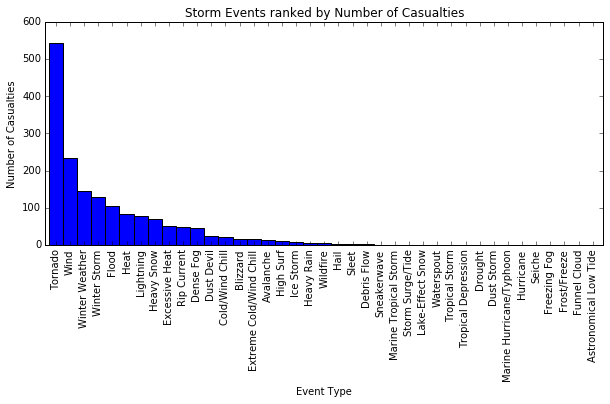

In [17]:
ax2 = df.groupby(['EVENT_TYPE']).sum()['CASUALTIES']
ax2 = ax2.sort_values(ascending=False)
ax2 = ax2.plot(kind='bar',width=1,figsize=(10,4))
ax2.set_xlabel("Event Type")
ax2.set_ylabel("Number of Casualties")
ax2.set_title("Storm Events ranked by Number of Casualties")
#Correlations
ax2a = df['EVENT_TYPE'].value_counts()
ax2b = df.groupby(['EVENT_TYPE']).sum()['CASUALTIES']
ax2a.corr(ax2b)

In [18]:
df.corr()['CASUALTIES']

EPISODE_ID   -0.004733
EVENT_ID     -0.004844
MAGNITUDE     0.016609
TOR_LENGTH    0.221514
TOR_WIDTH     0.130926
CASUALTIES    1.000000
DAMAGES            NaN
DURATION     -0.001560
Name: CASUALTIES, dtype: float64

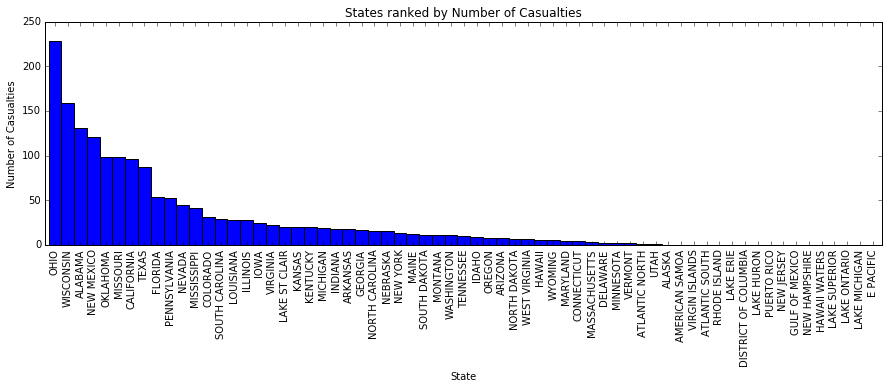

In [19]:
ax3 = df.groupby(['STATE']).sum()['CASUALTIES']
ax3 = ax3.sort_values(ascending=False)
ax3 = ax3.plot(kind="bar",width=1,figsize=(15,4))
ax3.set_xlabel("State")
ax3.set_ylabel("Number of Casualties")
ax3.set_title("States ranked by Number of Casualties")

In [20]:
tor_factors = ['TOR_F_SCALE','TOR_LENGTH','TOR_WIDTH']

df_flood = df[df['EVENT_TYPE']=="Flood"].drop(['EVENT_TYPE','MAGNITUDE','MAGNITUDE_TYPE']+tor_factors,axis=1)
df_wind = df[df['EVENT_TYPE']=="Wind"].drop(['EVENT_TYPE','FLOOD_CAUSE']+tor_factors,axis=1)
df_hail = df[df['EVENT_TYPE']=="Hail"].drop(['EVENT_TYPE','FLOOD_CAUSE','MAGNITUDE_TYPE']+tor_factors,axis=1)
df_tornado = df[df['EVENT_TYPE']=="Tornado"].drop(['EVENT_TYPE','MAGNITUDE','MAGNITUDE_TYPE'],axis=1)
print(df.shape, df_flood.shape, df_wind.shape, df_hail.shape, df_tornado.shape)

((46621, 17), (6853, 11), (18262, 12), (6808, 11), (1370, 14))


In [21]:
print(df_wind['MAGNITUDE_TYPE'].unique())
print(df_flood['FLOOD_CAUSE'].unique())

['EG' 'MG' 'MS' 'ES']
['Heavy Rain' 'Ice Jam' 'Heavy Rain / Snow Melt' 'Heavy Rain / Burn Area'
 nan 'Dam / Levee Break' 'Planned Dam Release']


In [22]:
df_flood_fat = df_flood[df_flood['CASUALTIES']>0]
df_wind_fat = df_wind[df_wind['CASUALTIES']>0]
df_hail_fat = df_hail[df_hail['CASUALTIES']>0]
df_tornado_fat = df_tornado[df_tornado['CASUALTIES']>0]
print(df_flood_fat.shape, df_wind_fat.shape, df_hail_fat.shape, df_tornado_fat.shape)

((63, 11), (112, 12), (2, 11), (62, 14))


# Experimenting with geographic data

Using land cover data to understand geography of locations, extract land-cover classification from .tif files.

In [23]:
raw_map = rio.open("Data/Raw Data Files/RenderData.tif")

IGBP Classes (1-17 -> 0-16): http://www.eomf.ou.edu/static/IGBP.pdf

Source algorithm for classifications in image: https://eospso.nasa.gov/sites/default/files/atbd/atbd_mod12.pdf

Source data: https://neo.sci.gsfc.nasa.gov/view.php?datasetId=MCD12C1_T1

In [24]:
print(raw_map.name, raw_map.count)
print(raw_map.height, raw_map.width) #number of rows, number of columns
print(raw_map.index(-94.64,30.11)) #takes longitude, then latitude
print(raw_map.bounds)

('Data/Raw Data Files/RenderData.tif', 1)
(1800, 3600)
(598, 853)
BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)


In [25]:
rb = raw_map.read(1)
x,y = raw_map.index(-94.64,30.11) 
print(rb.shape)
rb[x,y]
print(rb.max(), rb.min())

(1800, 3600)
(16, 0)
